### Задача

В файле представлены некоторые данные из Яндекс.Метрики по рекламным кампаниям банка.  
"Target" содержит 1 или 0, где 1 - это конверсия, 0 - нет.  
"Bid" - ставка, которую банк был готов заплатить за клик по рекламе.  
"Расходы" - сколько реально было потрачено за этот клик.  

Колонка "Условие показа объявления" была закодирована:  
"Условие показа объявления hashed" - здесь хэши той же длины, что и реальное слово и, соответственно, имеют ту же частоту.  
"Условие показа объявления embedding" - эмбединги для условия показа объявления.  

**Задача:** Банку нужно максимизировать конверсии, но при этом не тратить слишком много денег. Конверсию хотелось бы получать не дороже 4000 рублей, а для лендинга `landing_trial` не дороже 500 рублей.

In [1]:
# !pip install pyarrow

#### План действий

1. Найдём кампании, которые выбиваются из бюджета (стоимость конверсии больше 4000). 
2. Найдём кампании, которые разворачиваются на лендинге `landing_trial` и выбиваются из бюджета (для этого лендинга стоимость конверсии не должна быть больше 500).
3. Сравним дорогие и дешёвые кампании, а также кампании с высокой и низкой конверсией, чтобы понять, что влияет на конверсию и стоимость.
4. Построим модель, которая предсказывает вероятность конверсии, основываясь на том, что мы можем менять (например, условия показа). Это поможет в создании эффективных кампаний (с высокой конверсией и низкой стоимостью). 

In [2]:
import pandas as pd
import pyarrow.parquet as pq
import requests
from io import BytesIO
pd.options.mode.chained_assignment = None

In [3]:
table = pq.read_table('data_file.parquet')
df: pd.DataFrame = table.to_pandas()

In [4]:
pd.set_option('display.max_columns', 150)
df.head()

,дата визита с временем (мин),id визита,id клиента,Кампания Яндекс.Директа,Группа объявлений,Тип условия показа объявления,utmcontent,время на сайте (сек),регион,округ,размер города,тип сети,рекламная система,марка телефона,операционная система,тип операционной системы,ym_s_ipaddress,ym_s_cookieenabled,ym_s_javascriptenabled,ym_s_browser,matchedkeyword,keyword_id,utmmedium,landing,ym_s_isnewuser,ym_s_screenformat,placement,расходы,bid,target,Условие показа объявления embedding,Условие показа объявления hashed
0,2023-03-27 00:32:00+00:00,1492538189036126363,1679866369380985225,83101661,5130020019,<NA>,group_5130020019_banner_13472642339_device_mob...,8,Республика Татарстан,Приволжский федеральный округ,Миллионер (более 800 тыс.),<NA>,Яндекс: Директ,xiaomi,android,mobile_Android,83.220.238.xxx,1,1,chromemobile,<NA>,43260174282,search,landing_1,1,9:21,Яндекс,17.08,77.0,0,"[-0.025403419509530067, 0.0008466679719276726,...",d0633b 4575eb
1,2023-03-27 00:46:00+00:00,1492753384505344130,1679867202359463034,84460901,5148420803,additional,group_5148420803_banner_13648891761_device_mob...,15,Москва и Московская область,Центральный федеральный округ,Мультимиллионер (более 2 млн.),<NA>,Яндекс: Директ,motorola,android,mobile_Android,31.173.80.xxx,1,1,chromemobile,<NA>,43694449049,search,landing_2,1,9:21,Яндекс,NaN,NaN,0,"[-0.0059991320595145226, -0.014896205626428127...",37f936f1647bcb66 446f6f b76 4d3e3
2,2023-03-27 00:49:00+00:00,1492795918507573312,1679867364911838990,73266426,4883778384,additional,group_4883778384_banner_12006749216_device_mob...,176,Москва и Московская область,Центральный федеральный округ,Мультимиллионер (более 2 млн.),wi_fi,Яндекс: Директ,xiaomi,android,mobile_Android,31.173.82.xxx,1,1,chromemobile,<NA>,38082984228,search,landing_3,1,9:16,Яндекс,NaN,NaN,0,"[-0.004147370345890522, 0.007261834107339382, ...",8c4dbef21b13 4d3e3 4941d862e239
3,2023-03-27 00:56:00+00:00,1492907643497611594,1679867790182918776,83101661,5130020019,<NA>,group_5130020019_banner_13472642339_device_des...,1,Республика Татарстан,Приволжский федеральный округ,Миллионер (более 800 тыс.),<NA>,Яндекс: Директ,<NA>,macos,desktop,94.25.169.xxx,1,1,safari,<NA>,43260174282,search,landing_1,1,4:3,Яндекс,17.08,77.0,0,"[-0.025403419509530067, 0.0008466679719276726,...",d0633b 4575eb
4,2023-03-27 00:58:00+00:00,1492941307608301685,167986791979834461,71055059,4814182501,additional,group_4814182501_banner_11701152844_device_mob...,82,Москва и Московская область,Центральный федеральный округ,Мультимиллионер (более 2 млн.),wi_fi,Яндекс.Директ: Не определено,samsung,android,mobile_Android,31.173.86.xxx,1,1,chromemobile,<NA>,36288862077,search,landing_3,1,8,Яндекс,NaN,NaN,0,"[-0.019182218238711357, -0.012728818692266941,...",d0633b b91e b76 4d3e3


Чуть детальнее посмотрим, какие данные у нас есть, все ли значения известны и какого они типа.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32922 entries, 0 to 32921
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype                  
---  ------                               --------------  -----                  
 0   дата визита с временем (мин)         32922 non-null  datetime64[ns, Etc/UTC]
 1   id визита                            32922 non-null  string                 
 2   id клиента                           32922 non-null  string                 
 3   Кампания Яндекс.Директа              32922 non-null  string                 
 4   Группа объявлений                    32922 non-null  string                 
 5   Тип условия показа объявления        18133 non-null  string                 
 6   utmcontent                           32922 non-null  string                 
 7   время на сайте (сек)                 32922 non-null  int32                  
 8   регион                               32922 non-null  string       

Сколько вообще кампаний присутствует в выгрузке?

In [6]:
df['Кампания Яндекс.Директа'].unique()

<StringArray>
['83101661', '84460901', '73266426', '71055059', '83101660', '70963842',
 '73138660', '73266362', '71055140', '70963883',
 ...
 '65435711', '82774213', '82798267', '78241258', '80707553', '80697931',
 '65495228', '85467834', '85466017', '85465133']
Length: 150, dtype: string

Сейчас мы будем создавать новые колонки и удалять некоторые данные. На всякий случай забэкапим всё в текущем виде. 

In [7]:
df_backup = df.copy()

Если расходы не указаны, мы не сможем обработать эти данные, поэтому уберём объекты с пропущенными значениями в этом столбце.

А есть ли случаи, когда расходы равны нулю, но при этом конверсия есть?

In [8]:
zero_cost = df[df['расходы'] == 0]
zero_cost[zero_cost['target'] == 1]

,дата визита с временем (мин),id визита,id клиента,Кампания Яндекс.Директа,Группа объявлений,Тип условия показа объявления,utmcontent,время на сайте (сек),регион,округ,размер города,тип сети,рекламная система,марка телефона,операционная система,тип операционной системы,ym_s_ipaddress,ym_s_cookieenabled,ym_s_javascriptenabled,ym_s_browser,matchedkeyword,keyword_id,utmmedium,landing,ym_s_isnewuser,ym_s_screenformat,placement,расходы,bid,target,Условие показа объявления embedding,Условие показа объявления hashed
408,2023-03-27 11:01:00+00:00,1502417162810687777,167990406635198479,76443317,4972788453,phrase,group_4972788453_banner_12437929014_device_mob...,444,Москва и Московская область,Центральный федеральный округ,Мультимиллионер (более 2 млн.),<NA>,Яндекс: Директ,apple,ios_double,mobile_iOS,2a09:bac2:50c7:341::xxx,1,1,safari_mobile,<NA>,39971034688,search,landing_5,1,9:21,Яндекс,0.0,0.0,1,"[-0.03579997643828392, -0.0314190499484539, 0....",ce9d0b 022a 2cd604b
551,2023-03-27 21:09:00+00:00,1511990259647774949,1679940585791185215,76443317,4972788453,phrase,group_4972788453_banner_12437929014_device_mob...,36,Москва и Московская область,Центральный федеральный округ,Мультимиллионер (более 2 млн.),<NA>,Яндекс: Директ,apple,ios_double,mobile_iOS,2a00:1fa0:48f:bc7f::xxx,1,1,safari_mobile,<NA>,39971034688,search,landing_5,1,9:21,Яндекс,0.0,0.0,1,"[-0.03579997643828392, -0.0314190499484539, 0....",ce9d0b 022a 2cd604b
573,2023-03-27 23:09:00+00:00,1513869562947567737,1679947754621236230,76443317,4972788440,phrase,group_4972788440_banner_12437929005_device_des...,220,Москва и Московская область,Центральный федеральный округ,Мультимиллионер (более 2 млн.),<NA>,Яндекс: Директ,<NA>,windows,desktop,2a02:2168:83c0:f500::xxx,1,1,chrome,<NA>,39971034644,search,landing_5,1,16:9,Яндекс,0.0,0.0,1,"[-0.020507534965872765, -0.014434657990932465,...",d0633b 2b6e 4d3e3 4941d862e239 1b0 9982 5d 5e2...
631,2023-03-29 07:37:00+00:00,1544516593297653966,1680064656811193428,76443317,4972788453,phrase,group_4972788453_banner_12437929014_device_mob...,105,Москва и Московская область,Центральный федеральный округ,Мультимиллионер (более 2 млн.),<NA>,Яндекс: Директ,apple,ios_double,mobile_iOS,91.193.178.xxx,1,1,safari_mobile,<NA>,39971034682,search,landing_5,0,9:16,Яндекс,0.0,0.0,1,"[-0.04203077778220177, -0.016531044617295265, ...",ce9d0b 022a b90e1f8 7e93861 f8243de 2cd604b 9c...
661,2023-02-10 09:48:00+00:00,482064214661267705,1654163724783153731,76443317,4972788448,phrase,group_4972788448_banner_12437928972_device_des...,71,Москва и Московская область,Центральный федеральный округ,Мультимиллионер (более 2 млн.),<NA>,Яндекс: Директ,<NA>,macos,desktop,188.123.230.xxx,1,1,yandex_browser,<NA>,39971034540,search,landing_5,1,16:10,Яндекс,0.0,0.0,1,"[-0.039045531302690506, -0.01909749209880829, ...",ce9d0b 022a eb8 c0b b90e1f8 9fe99ca357 674f8b ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32420,2023-03-31 18:02:00+00:00,1599645544769650810,1680274962589595511,76443317,4972788453,phrase,group_4972788453_banner_12437929014_device_mob...,143,Москва и Московская область,Центральный федеральный округ,Мультимиллионер (более 2 млн.),<NA>,Яндекс: Директ,apple,ios_double,mobile_iOS,176.59.50.xxx,1,1,safari_mobile,<NA>,39971034688,search,landing_3,1,9:16,Яндекс,0.0,0.0,1,"[-0.03579997643828392, -0.0314190499484539, 0....",ce9d0b 022a 2cd604b
32615,2022-12-27 07:23:00+00:00,7727532887994269757,1672114998609662700,76443317,4972788446,phrase,group_4972788446_banner_12437928995_device_mob...,60,Санкт-Петербург и Ленинградская область,Северо-Западный федеральный округ,Мультимиллионер (более 2 млн.),<NA>,Яндекс: Директ,apple,ios_double,mobile_iOS,2606:54c0:6180:20::xxx,1,1,safari_mobile,<NA>,39971034476,search,landing_5,1,9:16,<NA>,0.0,0.0,1,"[-0.03732291981577873, -0.035322051495313644, ...",ce9d0b 022a d801ec68e8a 8c82c
32616,2022-12-27 07:25:00+00:00,7727561445719933133,1672114998609662

In [9]:
df.dropna(subset=['расходы'], inplace=True) # Нулевые расходы считаем валидными, удаляем только NaN

In [10]:
df.isna().sum()

дата визита с временем (мин)               0
id визита                                  0
id клиента                                 0
Кампания Яндекс.Директа                    0
Группа объявлений                          0
Тип условия показа объявления           5853
utmcontent                                 0
время на сайте (сек)                       0
регион                                     0
округ                                      0
размер города                             22
тип сети                               10410
рекламная система                          0
марка телефона                          5690
операционная система                       0
тип операционной системы                   0
ym_s_ipaddress                             0
ym_s_cookieenabled                         0
ym_s_javascriptenabled                     0
ym_s_browser                               0
matchedkeyword                         20849
keyword_id                                 0
utmmedium 

Рассчитаем стоимость конверсии для каждой кампании и создадим дополнительную колонку.
Для этого группируем данные по кампаниям, суммируем расходы и разделим на общее число конверсий.

In [11]:
import numpy as np

# CPA - cost per action

cpa_per_campaign = df.groupby('Кампания Яндекс.Директа').agg({'расходы':'sum', 'target':'sum'})
cpa_per_campaign['CPA'] = np.where(cpa_per_campaign['target'] == 0, np.nan, cpa_per_campaign['расходы'] / cpa_per_campaign['target'])
df['campaign_CPA'] = df['Кампания Яндекс.Директа'].map(cpa_per_campaign['CPA'])
df.head()

,дата визита с временем (мин),id визита,id клиента,Кампания Яндекс.Директа,Группа объявлений,Тип условия показа объявления,utmcontent,время на сайте (сек),регион,округ,размер города,тип сети,рекламная система,марка телефона,операционная система,тип операционной системы,ym_s_ipaddress,ym_s_cookieenabled,ym_s_javascriptenabled,ym_s_browser,matchedkeyword,keyword_id,utmmedium,landing,ym_s_isnewuser,ym_s_screenformat,placement,расходы,bid,target,Условие показа объявления embedding,Условие показа объявления hashed,campaign_CPA
0,2023-03-27 00:32:00+00:00,1492538189036126363,1679866369380985225,83101661,5130020019,<NA>,group_5130020019_banner_13472642339_device_mob...,8,Республика Татарстан,Приволжский федеральный округ,Миллионер (более 800 тыс.),<NA>,Яндекс: Директ,xiaomi,android,mobile_Android,83.220.238.xxx,1,1,chromemobile,<NA>,43260174282,search,landing_1,1,9:21,Яндекс,17.080000,77.0,0,"[-0.025403419509530067, 0.0008466679719276726,...",d0633b 4575eb,NaN
3,2023-03-27 00:56:00+00:00,1492907643497611594,1679867790182918776,83101661,5130020019,<NA>,group_5130020019_banner_13472642339_device_des...,1,Республика Татарстан,Приволжский федеральный округ,Миллионер (более 800 тыс.),<NA>,Яндекс: Директ,<NA>,macos,desktop,94.25.169.xxx,1,1,safari,<NA>,43260174282,search,landing_1,1,4:3,Яндекс,17.080000,77.0,0,"[-0.025403419509530067, 0.0008466679719276726,...",d0633b 4575eb,NaN
5,2023-03-27 01:10:00+00:00,1493124246017409235,1679868615133085797,83101660,5130019995,<NA>,group_5130019995_banner_13472642315_device_des...,0,Республика Татарстан,Приволжский федеральный округ,Миллионер (более 800 тыс.),<NA>,Яндекс: Директ,<NA>,windows,desktop,83.220.238.xxx,1,1,firefox,<NA>,43260171631,search,landing_4,1,4:3,Яндекс,111.936667,77.0,0,"[-0.025403419509530067, 0.0008466679719276726,...",d0633b 4575eb,13872.865000
6,2023-03-27 01:11:00+00:00,1493138852141596732,1679868672244713991,83101661,5130020019,<NA>,group_5130020019_banner_13472642339_device_des...,0,Республика Татарстан,Приволжский федеральный округ,Миллионер (более 800 тыс.),<NA>,Яндекс: Директ,<NA>,windows,desktop,83.220.239.xxx,1,1,firefox,<NA>,43260174282,search,landing_1,1,4:3,Яндекс,17.080000,77.0,0,"[-0.025403419509530067, 0.0008466679719276726,...",d0633b 4575eb,NaN
7,2023-03-27 01:13:00+00:00,1493173227407016203,167986880350249031,70963842,4811905474,phrase,group_4811905474_banner_11692383380_device_mob...,35,Москва и Московская область,Центральный федеральный округ,Средний (100-500 тыс.),wi_fi,Яндекс: Директ,vivo,android,mobile_Android,95.31.188.xxx,1,1,yandexsearch,<NA>,36236039073,search,landing_3,1,9:21,Яндекс,370.370000,3000.0,0,"[-0.021845361217856407, -0.01604992337524891, ...",d0633b 2b6e 4d3e3 4941d862e239 1b0 9982 5d 5e2...,9948.384348


Посмотрим самые расходные кампании.

In [12]:
df.groupby('Кампания Яндекс.Директа')['campaign_CPA'].mean().sort_values(ascending=False).head(10)

Кампания Яндекс.Директа
73118146    40524.440000
70964996    39443.423333
73118125    31238.010000
71055059    28263.136667
78219081    27822.760000
73265898    25613.593333
70961386    25316.600000
73266362    22178.636667
71055140    21851.169167
73265909    20672.473902
Name: campaign_CPA, dtype: float64

Для антилидера стоимость конверсии в десять раз выше ожидаемой.

Посмотрим также на самые дешёвые кампании.

In [13]:
df.groupby('Кампания Яндекс.Директа')['campaign_CPA'].mean().sort_values(ascending=True).head(10)

Кампания Яндекс.Директа
85467834      0.000
70965237     45.875
73139296    114.930
82798267    126.970
85468761    179.080
85467983    193.950
85465133    215.270
82769421    270.250
82770338    471.740
85469028    495.870
Name: campaign_CPA, dtype: float64

Какие рекламные кампании выбиваются за рамки бюджета? Пока не учитываем лендинг `action.norvikbank.ru/currency_exchange`. Его мы посмотрим отдельно. 

In [14]:
df[df['campaign_CPA'] > 4000]['Кампания Яндекс.Директа'].unique()

<StringArray>
['83101660', '70963842', '73266362', '70963883', '71054992', '70962367',
 '84460901', '73265898', '70964996', '71055059', '70961902', '73118146',
 '73266426', '73265909', '71054240', '73118088', '71055140', '71054852',
 '70964956', '70964876', '70962443', '78203856', '73118125', '70962123',
 '78203857', '70964808', '71055647', '71055733', '73159368', '71055704',
 '71056178', '71055225', '71055362', '73179910', '70962035', '73139454',
 '71056147', '73159307', '71056520', '78219082', '73159323', '70961677',
 '71055605', '71054326', '78219081', '71070096', '70961386', '82766358',
 '82767140', '73118073', '70961793', '79689124']
Length: 52, dtype: string

52 из 150 рекламных кампаний имеют стоимость конверсии выше указанного порога. Их финансирование необходимо пересмотреть. 

Определим, какие из кампаний, разворачивающихся на лендинге action.norvikbank.ru/currency_exchange, имеют стоимость конверсии выше 500.

In [15]:
currency_exhange_land_camp = df[df['landing'] == 'landing_trial']
currency_exhange_land_camp[currency_exhange_land_camp['campaign_CPA'] > 500]['Кампания Яндекс.Директа'].unique()

<StringArray>
[]
Length: 0, dtype: string

Есть два варианта, почему результат пуст:
1. Все кампании укладываются в бюджет.
2. Кампании на лендинге имеют нулевую конверсию (количество привлечённых пользователей равно нулю).

Посмотрим конверсию на разных лендингах. Обратим внимание на лендинг `landing_trial`

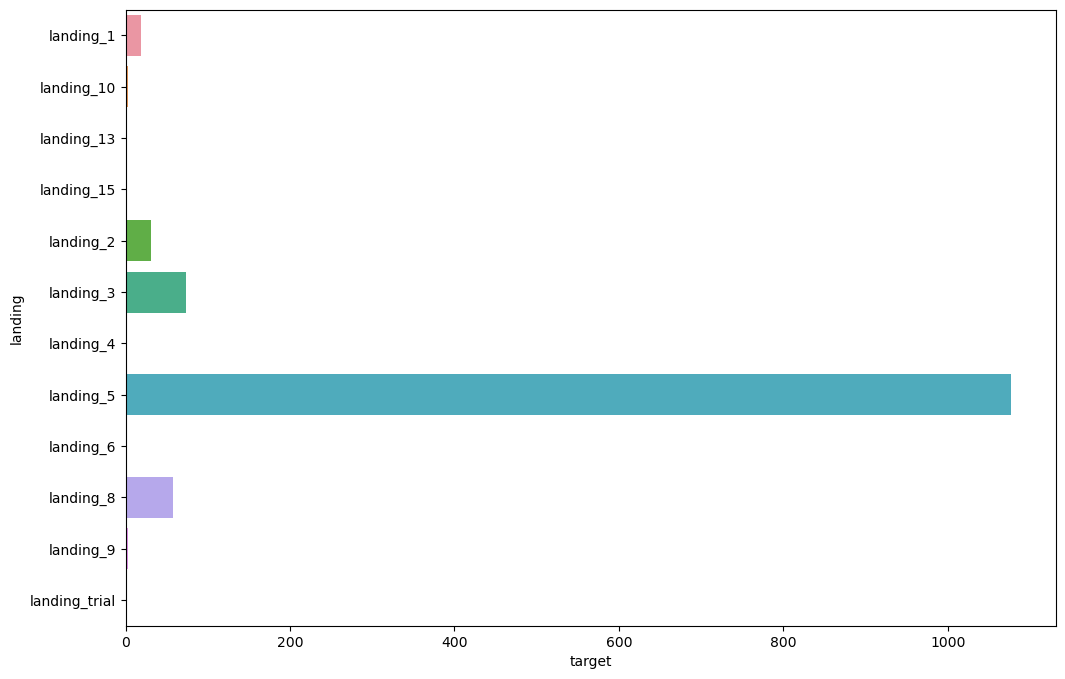

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

landing_conversion = df.groupby('landing')['target'].sum().reset_index()

plt.figure(figsize=(12,8))
sns.barplot(data=landing_conversion, x="target", y="landing", orient="h")
plt.show()

Лендинг `landing_trial` не привлёк ни одного пользователя. Вторая гипотеза верна. <br>
Есть и другие лендинги, которые не ведут к конверсии. Финансирование с них можно перенести на более эффективные.

Также заметим, что лендинг `landing_5` привлёк больше всего пользователей.

#### Выводы

* Мы нашли кампании, которые выбиваются из бюджета.
* Все кампании, разворачивающиеся на лендинге `landing_trial` не эффективны. Они не привлекли ни одного пользователя.

**Как мы можем оптимизировать расходы на рекламные кампании?** <br>
Посмотрим, какие кампании имеют более высокую конверсию.

Группируем данные по рекламным кампаниям, посчитаем конверсию (то есть количество привлечённых пользователей на общее количество пользователей) для каждой из них.

In [17]:
conv_campaign = df.groupby('Кампания Яндекс.Директа').agg({'target':'sum'}).rename(columns={'target':'target_sum'})

campaign_counts = df.groupby('Кампания Яндекс.Директа').size()

conv_campaign['part'] = conv_campaign['target_sum'] / campaign_counts

df['campaign_conv_rate'] = df['Кампания Яндекс.Директа'].map(conv_campaign['part'])

df.head()

,дата визита с временем (мин),id визита,id клиента,Кампания Яндекс.Директа,Группа объявлений,Тип условия показа объявления,utmcontent,время на сайте (сек),регион,округ,размер города,тип сети,рекламная система,марка телефона,операционная система,тип операционной системы,ym_s_ipaddress,ym_s_cookieenabled,ym_s_javascriptenabled,ym_s_browser,matchedkeyword,keyword_id,utmmedium,landing,ym_s_isnewuser,ym_s_screenformat,placement,расходы,bid,target,Условие показа объявления embedding,Условие показа объявления hashed,campaign_CPA,campaign_conv_rate
0,2023-03-27 00:32:00+00:00,1492538189036126363,1679866369380985225,83101661,5130020019,<NA>,group_5130020019_banner_13472642339_device_mob...,8,Республика Татарстан,Приволжский федеральный округ,Миллионер (более 800 тыс.),<NA>,Яндекс: Директ,xiaomi,android,mobile_Android,83.220.238.xxx,1,1,chromemobile,<NA>,43260174282,search,landing_1,1,9:21,Яндекс,17.080000,77.0,0,"[-0.025403419509530067, 0.0008466679719276726,...",d0633b 4575eb,NaN,0.000000
3,2023-03-27 00:56:00+00:00,1492907643497611594,1679867790182918776,83101661,5130020019,<NA>,group_5130020019_banner_13472642339_device_des...,1,Республика Татарстан,Приволжский федеральный округ,Миллионер (более 800 тыс.),<NA>,Яндекс: Директ,<NA>,macos,desktop,94.25.169.xxx,1,1,safari,<NA>,43260174282,search,landing_1,1,4:3,Яндекс,17.080000,77.0,0,"[-0.025403419509530067, 0.0008466679719276726,...",d0633b 4575eb,NaN,0.000000
5,2023-03-27 01:10:00+00:00,1493124246017409235,1679868615133085797,83101660,5130019995,<NA>,group_5130019995_banner_13472642315_device_des...,0,Республика Татарстан,Приволжский федеральный округ,Миллионер (более 800 тыс.),<NA>,Яндекс: Директ,<NA>,windows,desktop,83.220.238.xxx,1,1,firefox,<NA>,43260171631,search,landing_4,1,4:3,Яндекс,111.936667,77.0,0,"[-0.025403419509530067, 0.0008466679719276726,...",d0633b 4575eb,13872.865000,0.010753
6,2023-03-27 01:11:00+00:00,1493138852141596732,1679868672244713991,83101661,5130020019,<NA>,group_5130020019_banner_13472642339_device_des...,0,Республика Татарстан,Приволжский федеральный округ,Миллионер (более 800 тыс.),<NA>,Яндекс: Директ,<NA>,windows,desktop,83.220.239.xxx,1,1,firefox,<NA>,43260174282,search,landing_1,1,4:3,Яндекс,17.080000,77.0,0,"[-0.025403419509530067, 0.0008466679719276726,...",d0633b 4575eb,NaN,0.000000
7,2023-03-27 01:13:00+00:00,1493173227407016203,167986880350249031,70963842,4811905474,phrase,group_4811905474_banner_11692383380_device_mob...,35,Москва и Московская область,Центральный федеральный округ,Средний (100-500 тыс.),wi_fi,Яндекс: Директ,vivo,android,mobile_Android,95.31.188.xxx,1,1,yandexsearch,<NA>,36236039073,search,landing_3,1,9:21,Яндекс,370.370000,3000.0,0,"[-0.021845361217856407, -0.01604992337524891, ...",d0633b 2b6e 4d3e3 4941d862e239 1b0 9982 5d 5e2...,9948.384348,0.116751


Построим рядом графики конверсии и её стоимости. Наша задача увеличить конверсию, при этом по возможности снизить стоимость.

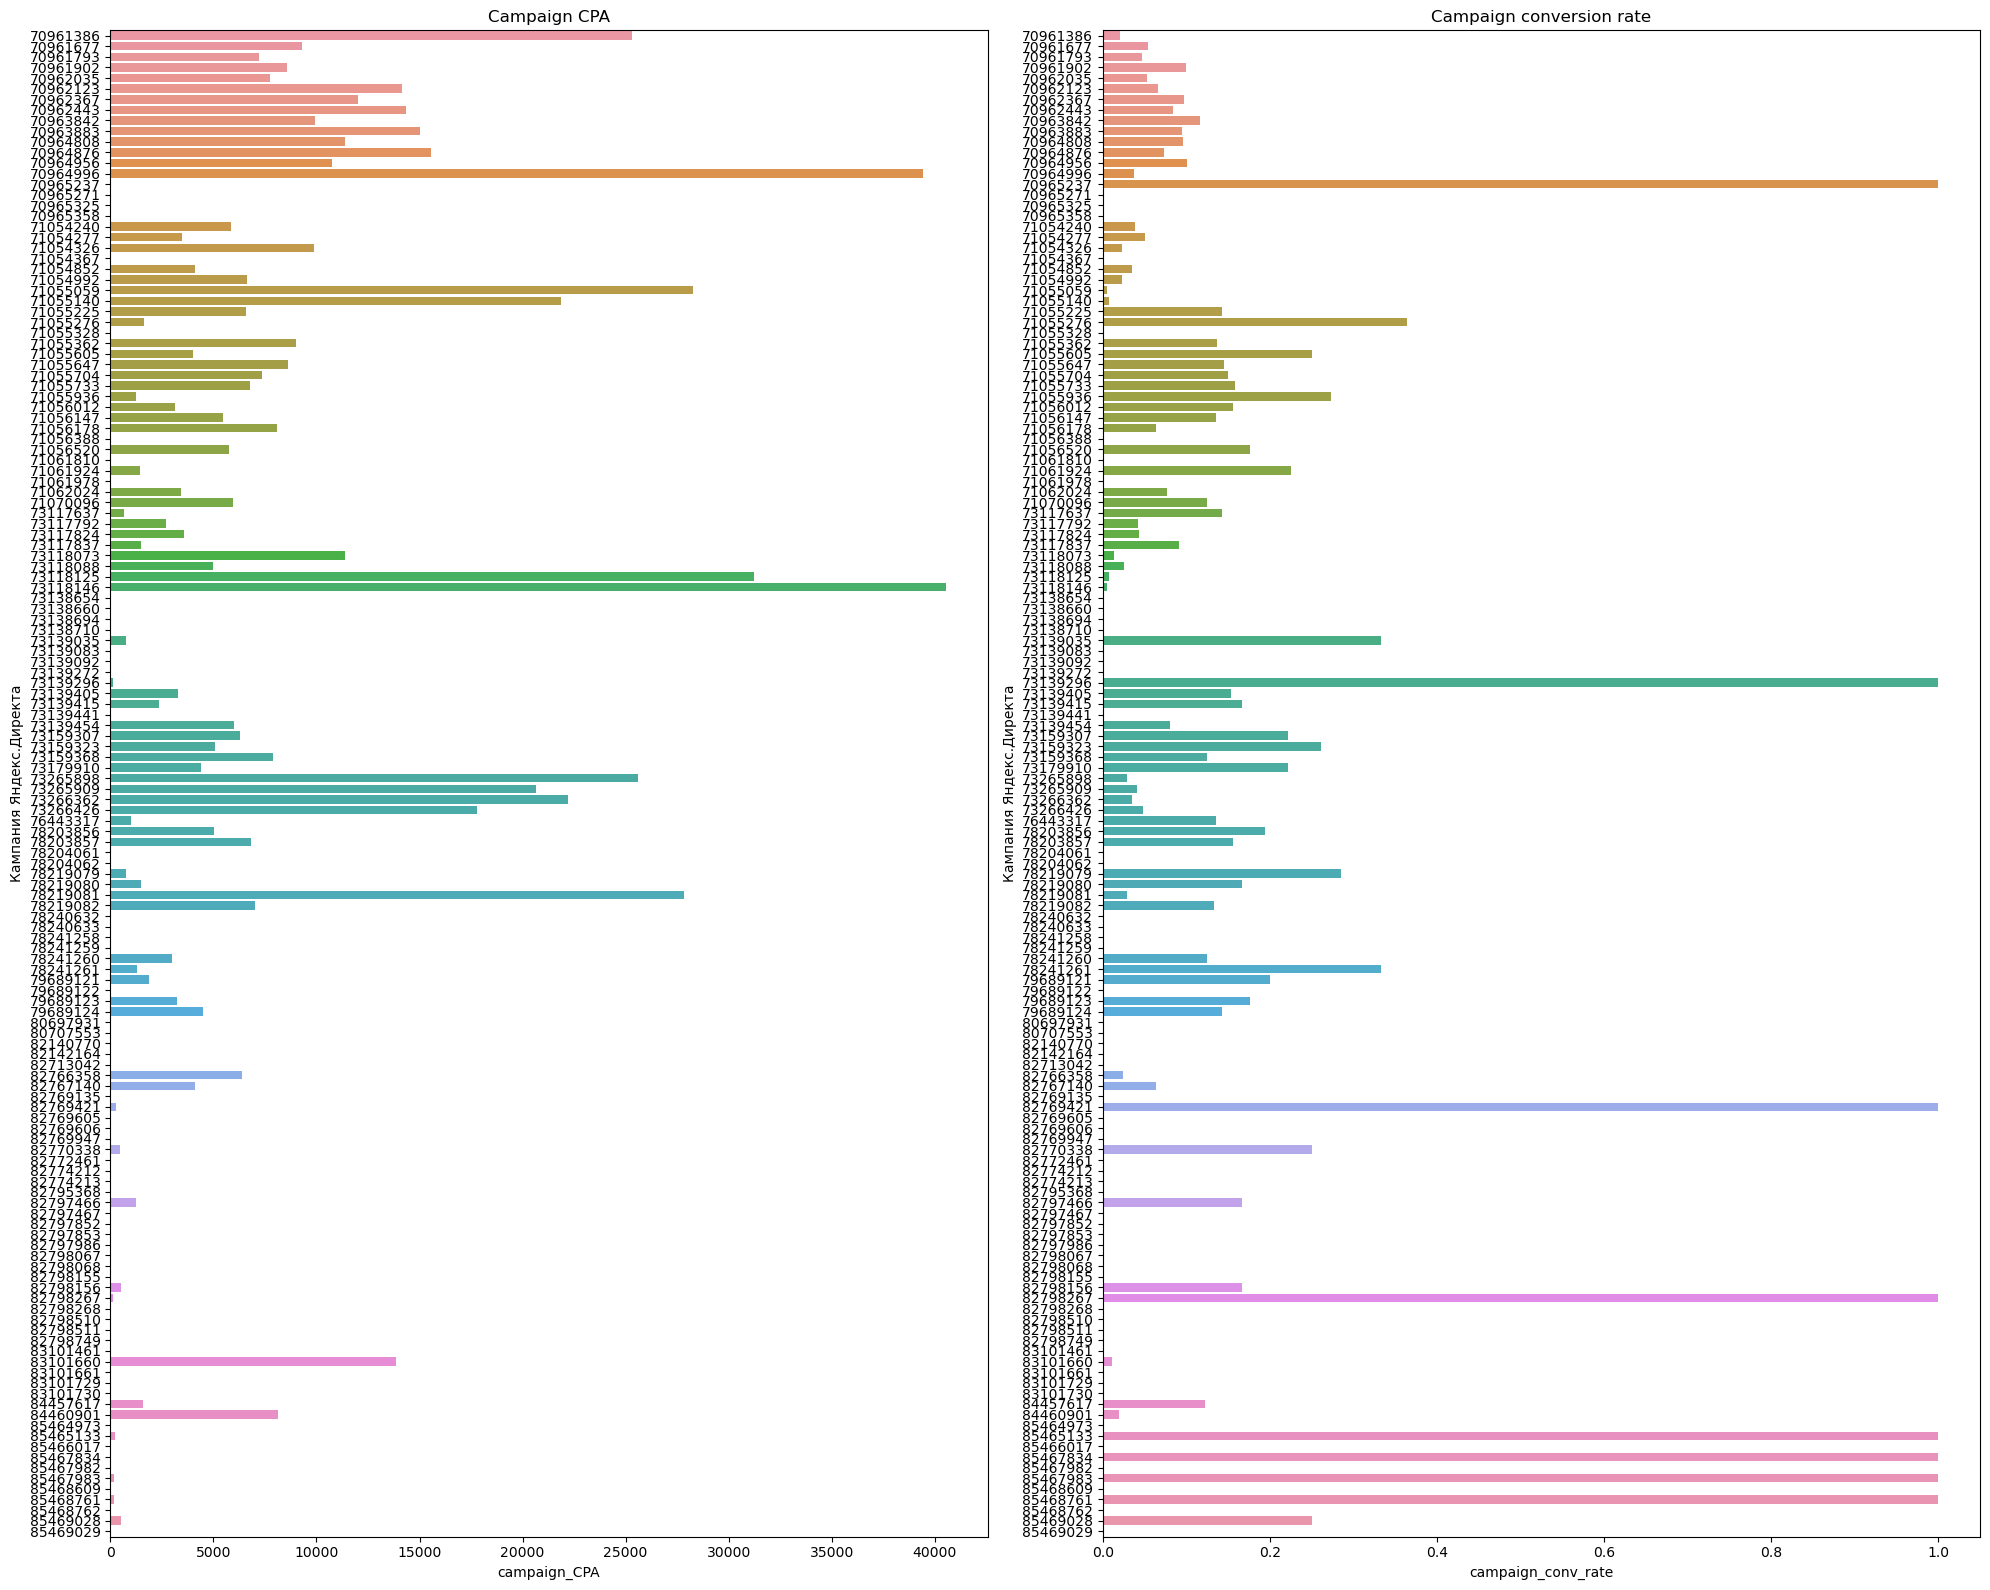

In [18]:
campaign_CPA_info = df.groupby('Кампания Яндекс.Директа')['campaign_CPA'].mean().reset_index()
campaign_target_info = df.groupby('Кампания Яндекс.Директа')['campaign_conv_rate'].mean().reset_index()

plt.figure(figsize=(20,16))

plt.subplot(1, 2, 1) 
sns.barplot(data=campaign_CPA_info, x="campaign_CPA", y="Кампания Яндекс.Директа", orient="h")
plt.title("Campaign CPA")

plt.subplot(1, 2, 2)
sns.barplot(data=campaign_target_info, x="campaign_conv_rate", y="Кампания Яндекс.Директа", orient="h")
plt.title("Campaign conversion rate")

plt.tight_layout()
plt.show()


Конверсия, равная 1, выглядит неправдоподобно. Посмотрим на все случаи (скорее всего их мало).

In [19]:
df[df['campaign_conv_rate'] == 1]

,дата визита с временем (мин),id визита,id клиента,Кампания Яндекс.Директа,Группа объявлений,Тип условия показа объявления,utmcontent,время на сайте (сек),регион,округ,размер города,тип сети,рекламная система,марка телефона,операционная система,тип операционной системы,ym_s_ipaddress,ym_s_cookieenabled,ym_s_javascriptenabled,ym_s_browser,matchedkeyword,keyword_id,utmmedium,landing,ym_s_isnewuser,ym_s_screenformat,placement,расходы,bid,target,Условие показа объявления embedding,Условие показа объявления hashed,campaign_CPA,campaign_conv_rate
657,2023-03-29 09:27:00+00:00,1546242441856942202,1678912575987810673,85467983,5161238254,phrase,group_5161238254_banner_13779726695_device_mob...,269,Нижегородская область,Приволжский федеральный округ,Миллионер (более 800 тыс.),cellular,Яндекс: Директ,huawei,android,mobile_Android,176.59.97.xxx,1,1,chromemobile,<NA>,43963723284,search,landing_2,0,9:21,Яндекс,193.950,77.0,1,"[-0.030607920140028, -0.005364447832107544, -0...",3a9 37f936f1647bcb66 f4d c528b9 5f008a7e,193.950,1.0
3099,2023-03-29 23:20:00+00:00,1559344821755969824,1680121228743014217,85468761,5161241067,phrase,group_5161241067_banner_13779846414_device_mob...,328,Саратовская область,Приволжский федеральный округ,Миллионер (более 800 тыс.),wi_fi,Яндекс: Директ,xiaomi,android,mobile_Android,46.254.80.xxx,1,1,miui,<NA>,43963868161,search,landing_2,1,9:21,Яндекс,179.080,195.0,1,"[-0.02143825963139534, -0.023282131180167198, ...",37f936f1647bcb66 446f6f,179.080,1.0
3807,2022-09-20 09:14:00+00:00,5509650711334092873,1663626195908595453,73139296,4881419675,phrase,group_4881419675_banner_11997613513_device_mob...,41,Санкт-Петербург и Ленинградская область,Северо-Западный федеральный округ,Малый (менее 100 тыс.),cellular,Яндекс: Директ,xiaomi,android,mobile_Android,188.170.83.xxx,1,1,chromemobile,<NA>,38000618255,search,landing_5,0,9:21,<NA>,114.930,312.0,1,"[-0.022306373342871666, 0.0016325133619830012,...",d0633b 2b6e 4d3e3 eb8 58fcbea0 447 9363054e217...,114.930,1.0
12409,2022-10-14 21:13:00+00:00,6064538927375057207,1665771179614266728,70965237,4811939090,additional,group_4811939090_banner_11692614575_device_mob...,86,Санкт-Петербург и Ленинградская область,Не определено,Не определено,wi_fi,Яндекс: Директ,huawei,android,mobile_Android,178.67.40.xxx,1,1,yandex_browser,<NA>,36236627189,search,landing_5,1,9:16,<NA>,45.875,135.0,1,"[-0.03340286388993263, -0.02554978057742119, 0...",859b04 022a 7e93861 083b45 3d0a8f2 2cd604b,45.875,1.0
12410,2022-10-14 21:16:00+00:00,6064595158899360086,1665771179614266728,70965237,4811939090,additional,group_4811939090_banner_11692614575_device_mob...,230,Санкт-Петербург и Ленинградская область,Не определено,Не определено,wi_fi,Яндекс: Директ,huawei,android,mobile_Android,178.67.40.xxx,1,1,yandex_browser,<NA>,36236627189,search,landing_5,0,9:16,<NA>,45.875,135.0,1,"[-0.03340286388993263, -0.02554978057742119, 0...",859b04 022a 7e93861 083b45 3d0a8f2 2cd604b,45.875,1.0
17821,2023-03-02 00:19:00+00:00,926092485840339156,167770556144231159,82769421,5124459039,phrase,group_5124459039_banner_13419199168_device_mob...,208,Саратовская область,Приволжский федеральный округ,Миллионер (более 800 тыс.),cellular,Яндекс: Директ,xiaomi,android,mobile_Android,176.59.98.xxx,1,1,chromemobile,<NA>,43122218851,search,landing_2,1,9:21,Яндекс,270.250,777.0,1,"[-0.025272194296121597, 0.00843747891485691, 0...",1d9 51de1f144 c721e4 942 b90aaad a16dd67e0e07 ...,270.250,1.0
20897,2023-03-24 20:19:00+00:00,1443246088209563771,1679689142278933140,82798267,5125101490,phrase,group_5125101490_banner_13425888018_device_mob...,293,Омская область,Сибирский федеральный округ,Миллионер (более 800 тыс.),wi_fi,Яндекс: Директ,xiaomi,android,mobile_Android,92.124.161.xxx,1,1,yandex_browser,<NA>,43144535919,search,landing_2,1,9:21,Яндекс,126.970,313.0,1,"[-0.03107169270515442, -0.005822634324431419, ...",b7f9ece6 c6fa5 f3b c584390cb8d42a2c 7ee5a10 a5...,126.970,1.0
32099,2023-03-30 22:03:00+00:00,1580780036681367878,1680202872737162193,85467

Конверсия, равная 1, означает, что только один пользователь видел рекламу. Эти данные не являются репрезентативными. Отфильтруем их. Остальные кампании сортируем по стоимости конверсии, начиная с самых дешёвых.

In [20]:
df = df[df['campaign_conv_rate'] != 1]
campaign_target_info = df.groupby('Кампания Яндекс.Директа').agg({'campaign_CPA':'mean', 'campaign_conv_rate':'mean', 'target':'sum'}).rename(columns={'target':'общее число привлечённых пользователей', 'campaign_CPA':'стоимость конверсии'}).reset_index()
campaign_target_info.sort_values(['стоимость конверсии'], ascending=True).head(20)

,Кампания Яндекс.Директа,стоимость конверсии,campaign_conv_rate,общее число привлечённых пользователей
102,82770338,471.740000,0.250000,1.0
132,85469028,495.870000,0.250000,1.0
115,82798156,532.560000,0.166667,1.0
44,73117637,670.410000,0.142857,2.0
56,73139035,775.050000,0.333333,1.0
77,78219079,780.985000,0.285714,2.0
72,76443317,981.057259,0.135469,592.0
33,71055936,1231.906667,0.272727,3.0
107,82797466,1237.420000,0.166667,1.0
86,78241261,1305.900000,0.333333,1.0


Кажется, что брать в качестве показателя эффективности только уровень конверсии не показательно: среди кампаний встречаются такие, у которых конверсия 17%, при этом они привлекли одного пользователя. Отберём кампании для дальнейшего рассмотрения, выставив трешхолд по количеству пользователей.

Какое число привлечённых пользователей встречается? Какими значениями можно принебречь как нерепрезентативными?

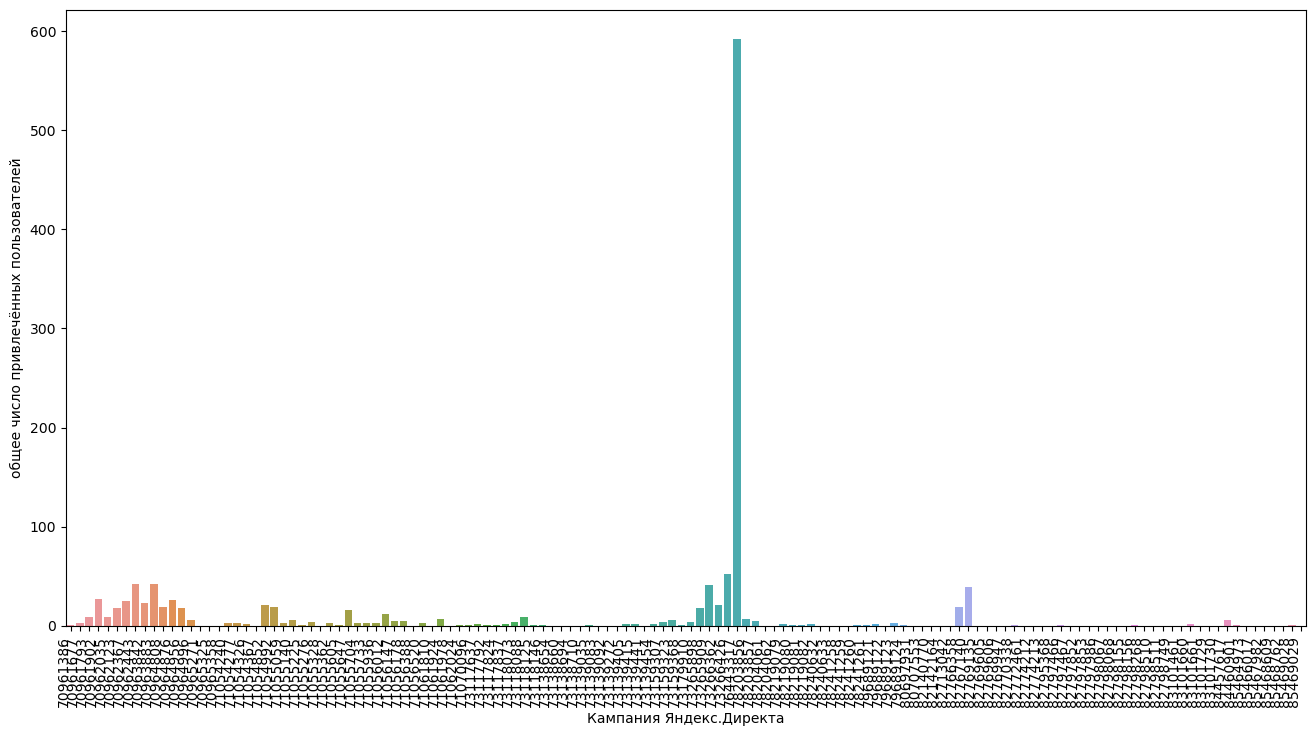

In [21]:
plt.figure(figsize=(16,8))

sns.barplot(data=campaign_target_info, x="Кампания Яндекс.Директа", y="общее число привлечённых пользователей", orient='v')
plt.xticks(rotation=90, ha='right')
plt.show()

Оставим в качестве объектов для наблюдения только те кампании, где число пользователей выше 10.

In [22]:
clean_campaign_target_info = campaign_target_info[campaign_target_info['общее число привлечённых пользователей'] > 10]
clean_campaigns = clean_campaign_target_info['Кампания Яндекс.Директа'].values
clean_campaigns

<StringArray>
['70961902', '70962123', '70962367', '70962443', '70963842', '70963883',
 '70964808', '70964876', '70964956', '71054852', '71054992', '71055647',
 '71056012', '73265898', '73265909', '73266362', '73266426', '76443317',
 '82766358', '82767140']
Length: 20, dtype: string

In [23]:
clean_df = df[df['Кампания Яндекс.Директа'].isin(clean_campaigns)]
clean_df

,дата визита с временем (мин),id визита,id клиента,Кампания Яндекс.Директа,Группа объявлений,Тип условия показа объявления,utmcontent,время на сайте (сек),регион,округ,размер города,тип сети,рекламная система,марка телефона,операционная система,тип операционной системы,ym_s_ipaddress,ym_s_cookieenabled,ym_s_javascriptenabled,ym_s_browser,matchedkeyword,keyword_id,utmmedium,landing,ym_s_isnewuser,ym_s_screenformat,placement,расходы,bid,target,Условие показа объявления embedding,Условие показа объявления hashed,campaign_CPA,campaign_conv_rate
7,2023-03-27 01:13:00+00:00,1493173227407016203,167986880350249031,70963842,4811905474,phrase,group_4811905474_banner_11692383380_device_mob...,35,Москва и Московская область,Центральный федеральный округ,Средний (100-500 тыс.),wi_fi,Яндекс: Директ,vivo,android,mobile_Android,95.31.188.xxx,1,1,yandexsearch,<NA>,36236039073,search,landing_3,1,9:21,Яндекс,370.370,3000.0,0,"[-0.021845361217856407, -0.01604992337524891, ...",d0633b 2b6e 4d3e3 4941d862e239 1b0 9982 5d 5e2...,9948.384348,0.116751
9,2023-03-27 01:42:00+00:00,1493635461382668438,1679870567781276186,73266362,4883777856,additional,group_4883777856_banner_12006742571_device_mob...,15,Москва и Московская область,Центральный федеральный округ,Мультимиллионер (более 2 млн.),wi_fi,Яндекс: Директ,xiaomi,android,mobile_Android,83.220.236.xxx,1,1,chromemobile,<NA>,38082965341,search,landing_3,1,9:16,Яндекс,810.975,3000.0,0,"[-0.0035422691144049168, -0.010816911235451698...",9add1 d0633b b76 4d3e3 4941d862e239,22178.636667,0.035000
11,2023-03-27 02:02:00+00:00,1493946038839935105,1679871750846522298,70963883,4811906643,phrase,group_4811906643_banner_11692389454_device_des...,90,Москва и Московская область,Не определено,Не определено,<NA>,Яндекс: Директ,<NA>,windows,desktop,91.205.168.xxx,1,1,yandex_browser,<NA>,36236061413,search,landing_3,1,16:9,Яндекс,1421.050,3000.0,0,"[-0.024592971429228783, 0.006339015439152718, ...",44e475 2b6e 4d3e3 4941d862e239 271c7b 251a4d 7...,15020.679762,0.094595
13,2023-03-27 02:07:00+00:00,1494025911167090776,1679872056828020963,71054992,4814180373,<NA>,group_4814180373_banner_11701148019_device_mob...,15,Москва и Московская область,Центральный федеральный округ,Средний (100-500 тыс.),wi_fi,Яндекс: Директ,xiaomi,android,mobile_Android,31.173.86.xxx,1,1,chromemobile,<NA>,36288816463,search,landing_1,1,10,Яндекс,219.590,700.0,0,"[-0.018445320427417755, -0.014867732301354408,...",d0633b b76 4d3e3,6613.570000,0.023370
25,2023-03-27 03:52:00+00:00,1495682296868241660,1679878376710605919,76443317,4972788446,<NA>,group_4972788446_banner_12437928992_device_des...,1,Москва и Московская область,Центральный федеральный округ,Мультимиллионер (более 2 млн.),<NA>,Яндекс: Директ,<NA>,windows,desktop,83.220.239.xxx,1,1,chrome,<NA>,39971034539,search,landing_5,1,16:9,Яндекс,0.000,0.0,0,"[-0.009552359580993652, -0.005822664126753807,...",d0633b b76 4d3e3 4941d862e239,981.057259,0.135469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32893,2022-12-31 12:44:00+00:00,7823179568069476673,1672479762492477753,76443317,4972788453,phrase,group_4972788453_banner_12437929015_device_mob...,78,Москва и Московская область,Центральный федеральный округ,Мультимиллионер (более 2 млн.),wi_fi,Яндекс: Директ,xiaomi,android,mobile_Android,62.217.191.xxx,1,1,yandex_browser,<NA>,39971034688,search,landing_5,0,9:21,<NA>,2400.000,0.0,1,"[-0.03579997643828392, -0.0314190499484539, 0....",ce9d0b 022a 2cd604b,981.057259,0.135469
32900,2022-12-31 15:50:00+00:00,7826106411816321238,1672491026242642380,70962443,4811884134,phrase,group_4811884134_banner_11692301758_device_mob...,258,Москва и Московская область,Не определено,Не определено,<NA>,Яндекс: Директ,apple,ios_double,mobile_iOS,188.35.130.xxx,1,1,yandexsearch,<NA>,36235682150,search,landing_1,1,9:21,<NA>,2314.950,3000.0,0,"[-0.01820322498679161, 0.004427270032465458, -...",d0633b 2b6e 4d3e3 4941d862e239 6866 46

Разделим данные на две группы:
* кампании, находящиеся в рамках бюджета (стоимость конверсии ниже или равна 4000),
* кампании, находящиеся за рамками бюджета (стоимость конверсии выше 4000).

Сравним две группы и выясним, от чего зависит конверсия. Если выявим закономерности, сможем пересмотреть дорогие кампании и снизить расходы на них.

In [24]:
cheap_campaigns = clean_df[clean_df['campaign_CPA'] <= 4000]
cheap_campaigns.head()

,дата визита с временем (мин),id визита,id клиента,Кампания Яндекс.Директа,Группа объявлений,Тип условия показа объявления,utmcontent,время на сайте (сек),регион,округ,размер города,тип сети,рекламная система,марка телефона,операционная система,тип операционной системы,ym_s_ipaddress,ym_s_cookieenabled,ym_s_javascriptenabled,ym_s_browser,matchedkeyword,keyword_id,utmmedium,landing,ym_s_isnewuser,ym_s_screenformat,placement,расходы,bid,target,Условие показа объявления embedding,Условие показа объявления hashed,campaign_CPA,campaign_conv_rate
25,2023-03-27 03:52:00+00:00,1495682296868241660,1679878376710605919,76443317,4972788446,<NA>,group_4972788446_banner_12437928992_device_des...,1,Москва и Московская область,Центральный федеральный округ,Мультимиллионер (более 2 млн.),<NA>,Яндекс: Директ,<NA>,windows,desktop,83.220.239.xxx,1,1,chrome,<NA>,39971034539,search,landing_5,1,16:9,Яндекс,0.0,0.0,0,"[-0.009552359580993652, -0.005822664126753807,...",d0633b b76 4d3e3 4941d862e239,981.057259,0.135469
26,2023-03-27 03:53:00+00:00,1495694000440475843,1679878376710605919,76443317,4972788446,<NA>,group_4972788446_banner_12437928992_device_des...,2,Москва и Московская область,Центральный федеральный округ,Мультимиллионер (более 2 млн.),<NA>,Яндекс: Директ,<NA>,windows,desktop,83.220.239.xxx,1,1,chrome,<NA>,39971034539,search,landing_5,0,16:9,Яндекс,0.0,0.0,0,"[-0.009552359580993652, -0.005822664126753807,...",d0633b b76 4d3e3 4941d862e239,981.057259,0.135469
47,2023-03-27 07:48:00+00:00,1499392771127771259,1627295558588782183,76443317,4972788453,phrase,group_4972788453_banner_12437929014_device_mob...,222,Москва и Московская область,Центральный федеральный округ,Мультимиллионер (более 2 млн.),wi_fi,Яндекс: Директ,xiaomi,android,mobile_Android,217.197.123.xxx,1,1,chromemobile,<NA>,39971034688,search,landing_5,0,9:21,Яндекс,0.0,0.0,0,"[-0.03579997643828392, -0.0314190499484539, 0....",ce9d0b 022a 2cd604b,981.057259,0.135469
49,2023-03-27 08:13:00+00:00,1499779246199406648,1679894004825623722,76443317,4972788448,additional,group_4972788448_banner_12437928972_device_tab...,34,Москва и Московская область,Центральный федеральный округ,Мультимиллионер (более 2 млн.),<NA>,Яндекс: Директ,apple,ios_double,mobile_iOS,109.252.109.xxx,1,1,yandex_browser,<NA>,39971034599,search,landing_5,1,3:4,Яндекс,570.0,0.0,0,"[-0.03125210851430893, -0.037369661033153534, ...",859b04 bd5a,981.057259,0.135469
57,2023-03-25 00:00:00+00:00,1446724928488603694,1679526182325003850,76443317,4972788453,phrase,group_4972788453_banner_12437929014_device_mob...,202,Санкт-Петербург и Ленинградская область,Северо-Западный федеральный округ,Малый (менее 100 тыс.),wi_fi,Яндекс: Директ,zte,android,mobile_Android,80.82.184.xxx,1,1,yandex_browser,<NA>,39971034680,search,landing_5,0,10,Яндекс,0.0,0.0,0,"[-0.030973533168435097, -0.02916390262544155, ...",ce9d0b 022a d801ec68e8a cea0 2cd604b,981.057259,0.135469


In [25]:
expensive_campaigns = clean_df[clean_df['campaign_CPA'] > 4000]
expensive_campaigns.head()

,дата визита с временем (мин),id визита,id клиента,Кампания Яндекс.Директа,Группа объявлений,Тип условия показа объявления,utmcontent,время на сайте (сек),регион,округ,размер города,тип сети,рекламная система,марка телефона,операционная система,тип операционной системы,ym_s_ipaddress,ym_s_cookieenabled,ym_s_javascriptenabled,ym_s_browser,matchedkeyword,keyword_id,utmmedium,landing,ym_s_isnewuser,ym_s_screenformat,placement,расходы,bid,target,Условие показа объявления embedding,Условие показа объявления hashed,campaign_CPA,campaign_conv_rate
7,2023-03-27 01:13:00+00:00,1493173227407016203,167986880350249031,70963842,4811905474,phrase,group_4811905474_banner_11692383380_device_mob...,35,Москва и Московская область,Центральный федеральный округ,Средний (100-500 тыс.),wi_fi,Яндекс: Директ,vivo,android,mobile_Android,95.31.188.xxx,1,1,yandexsearch,<NA>,36236039073,search,landing_3,1,9:21,Яндекс,370.370,3000.0,0,"[-0.021845361217856407, -0.01604992337524891, ...",d0633b 2b6e 4d3e3 4941d862e239 1b0 9982 5d 5e2...,9948.384348,0.116751
9,2023-03-27 01:42:00+00:00,1493635461382668438,1679870567781276186,73266362,4883777856,additional,group_4883777856_banner_12006742571_device_mob...,15,Москва и Московская область,Центральный федеральный округ,Мультимиллионер (более 2 млн.),wi_fi,Яндекс: Директ,xiaomi,android,mobile_Android,83.220.236.xxx,1,1,chromemobile,<NA>,38082965341,search,landing_3,1,9:16,Яндекс,810.975,3000.0,0,"[-0.0035422691144049168, -0.010816911235451698...",9add1 d0633b b76 4d3e3 4941d862e239,22178.636667,0.035000
11,2023-03-27 02:02:00+00:00,1493946038839935105,1679871750846522298,70963883,4811906643,phrase,group_4811906643_banner_11692389454_device_des...,90,Москва и Московская область,Не определено,Не определено,<NA>,Яндекс: Директ,<NA>,windows,desktop,91.205.168.xxx,1,1,yandex_browser,<NA>,36236061413,search,landing_3,1,16:9,Яндекс,1421.050,3000.0,0,"[-0.024592971429228783, 0.006339015439152718, ...",44e475 2b6e 4d3e3 4941d862e239 271c7b 251a4d 7...,15020.679762,0.094595
13,2023-03-27 02:07:00+00:00,1494025911167090776,1679872056828020963,71054992,4814180373,<NA>,group_4814180373_banner_11701148019_device_mob...,15,Москва и Московская область,Центральный федеральный округ,Средний (100-500 тыс.),wi_fi,Яндекс: Директ,xiaomi,android,mobile_Android,31.173.86.xxx,1,1,chromemobile,<NA>,36288816463,search,landing_1,1,10,Яндекс,219.590,700.0,0,"[-0.018445320427417755, -0.014867732301354408,...",d0633b b76 4d3e3,6613.570000,0.023370
32,2023-03-27 05:33:00+00:00,1497271705206259789,1679884438729911746,70962367,4811882151,phrase,group_4811882151_banner_11692292638_device_mob...,16,Москва и Московская область,Центральный федеральный округ,Малый (менее 100 тыс.),wi_fi,Яндекс: Директ,samsung,android,mobile_Android,31.185.7.xxx,1,1,yandexsearch,<NA>,36235658704,search,landing_1,1,9:21,Яндекс,263.940,3000.0,0,"[-0.006247757468372583, 0.006855088751763105, ...",3144e 44e475 2b6e 4d3e3 4941d862e239,12030.078000,0.096899


Посмотрим, какие из кампаний в обеих группах имеют наиболее высокую конверсию.

In [26]:
cheap_camp_info = cheap_campaigns.groupby('Кампания Яндекс.Директа').agg({'campaign_conv_rate':'mean', 'target':'sum', 'campaign_CPA':'mean'}).rename(columns={'target':'общее число привлечённых пользователей', 'campaign_CPA':'стоимость конверсии'})
cheap_camp_info.sort_values('campaign_conv_rate', ascending=False).head(20)

,campaign_conv_rate,общее число привлечённых пользователей,стоимость конверсии
Кампания Яндекс.Директа,,,
71056012,0.155844,12.0,3153.317500
76443317,0.135469,592.0,981.057259


In [27]:
expensive_camp_info = expensive_campaigns.groupby('Кампания Яндекс.Директа').agg({'campaign_conv_rate':'mean', 'target':'sum', 'campaign_CPA':'mean'}).rename(columns={'target':'общее число привлечённых пользователей', 'campaign_CPA':'стоимость конверсии'})
expensive_camp_info.sort_values('campaign_conv_rate', ascending=False).head(20)

,campaign_conv_rate,общее число привлечённых пользователей,стоимость конверсии
Кампания Яндекс.Директа,,,
71055647,0.145455,16,8628.546875
70963842,0.116751,23,9948.384348
70964956,0.100559,18,10770.961111
70961902,0.099265,27,8557.687407
70962367,0.096899,25,12030.078000
70964808,0.095960,19,11379.625263
70963883,0.094595,42,15020.679762
70962443,0.083665,42,14346.294048
70964876,0.073034,26,15535.692564


У нас две кампании, которые укладываются в бюджет и привлекают пользователей. И 18 перспективных кампаний, которые не укладываются в бюджет. <br>
Задача - сократить расходы на эти кампании, не потеряв в конверсии.

Посчитаем сколько людей заходит на сайт в рамках рекламной кампании, чтобы найти лендинги с высоким трафиком.

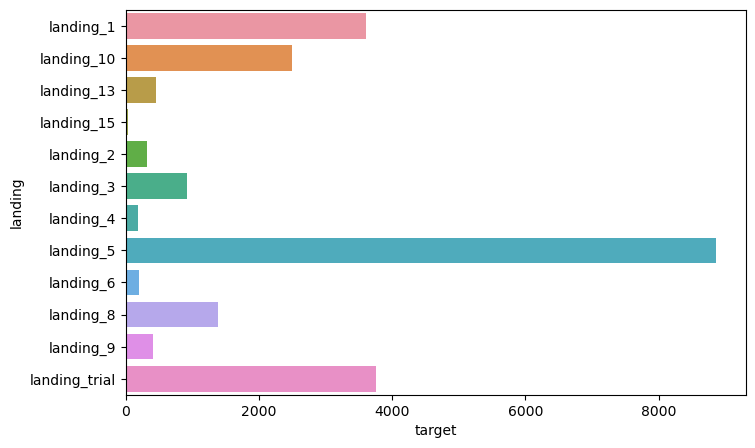

In [28]:
all_landing_conv = df.groupby('landing')['target'].count().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=all_landing_conv, x="target", y="landing", orient="h")
plt.show()

Поток пользователей на одних лендингах явно выше, чем на других. А на каких лендингах разворачиваются дорогие и дешёвые кампании? 

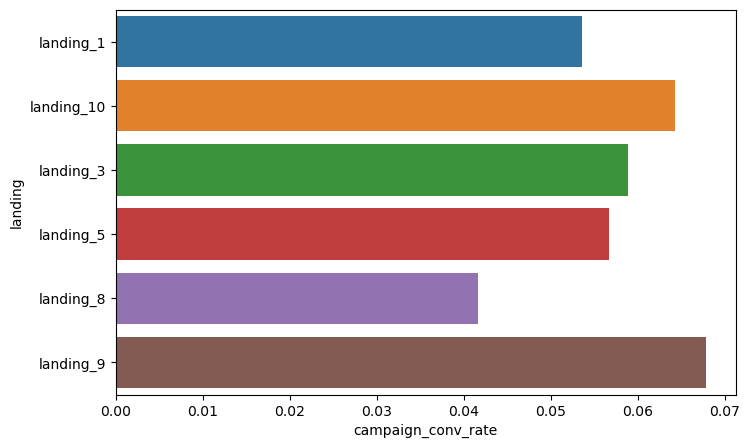

In [29]:
landing_conv = expensive_campaigns.groupby('landing')['campaign_conv_rate'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=landing_conv, x="campaign_conv_rate", y="landing", orient="h")
plt.show()

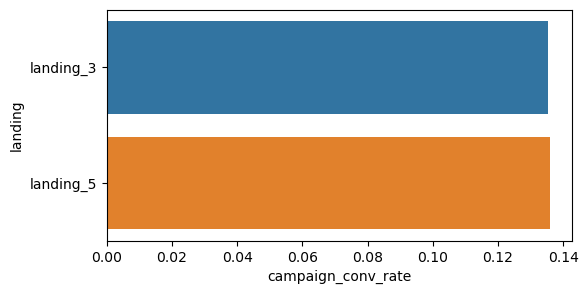

In [30]:
cheap_landing_conv = cheap_campaigns.groupby('landing')['campaign_conv_rate'].mean().reset_index()

plt.figure(figsize=(6,3))
sns.barplot(data=cheap_landing_conv, x="campaign_conv_rate", y="landing", orient="h")
plt.show()

Дешёвые и дорогие кампании разварачиваются на лендингах с высоким трафиком. При этом для дешёвых кампаний конверсия выше. Возможно, мы сможем снизить стоимость конверсии для дорогих кампаний, если увеличим уровень конверсии.

Рассмотрим лендинг `landing_5` (как самый посещаемый) подробнее.

In [31]:
loan_landing_exp_camp = expensive_campaigns[expensive_campaigns['landing'] == 'landing_5']

loan_exp_info = loan_landing_exp_camp.groupby('Кампания Яндекс.Директа').agg({
    'campaign_conv_rate': 'min',  # отразим минимальный процент конверсии
    'campaign_CPA': 'max',  # отразим максимальную стоимость конверсии
    'Условие показа объявления hashed': lambda x: set(x),  # получим список хэшированных условий показа объявления
    'keyword_id': lambda x: set(x)  # получим список ключевых слов
})

loan_exp_info.sort_values('campaign_conv_rate', ascending=False).head(20)

,campaign_conv_rate,campaign_CPA,Условие показа объявления hashed,keyword_id
Кампания Яндекс.Директа,,,,
71055647,0.145455,8628.546875,{d0633b 2b6e 4d3e3 4941d862e239 1b0 9982 5d 5e...,"{36289176315, 36289171892, 36289181060, 362891..."
70963842,0.116751,9948.384348,{d0633b 2b6e 4d3e3 4941d862e239 1b0 9982 5d 5e...,"{36236037345, 36236036935, 36236037713, 362360..."
70964956,0.100559,10770.961111,"{d0633b b76 4d3e3 4941d862e239, d0633b b76 4d3...","{36236527646, 36236530326, 36236527400, 362365..."
70961902,0.099265,8557.687407,"{b91e 2b6e be9e7841 4ef, a3c0a318 44e475 2b6e ...","{36235525280, 36235525056, 36235526437, 362355..."
70962367,0.096899,12030.078000,{d0633b 2b6e 4d3e3 4941d862e239 1b0 9982 5d 5e...,"{41904938816, 36235654105, 36235658917, 362356..."
70964808,0.095960,11379.625263,{d0633b b76 4d3e3 4941d862e239 1f 5237097a97 f...,"{36236467339, 36236467649, 41904936053, 362364..."
70963883,0.094595,15020.679762,{d0633b 2b6e 4d3e3 4941d862e239 1b0 9982 5d 5e...,"{36236067718, 36236061616, 36236065756, 362360..."
70962443,0.083665,14346.294048,{d0633b 2b6e 4d3e3 4941d862e239 1b0 9982 5d 5e...,"{41904938854, 41904938867, 36235674119, 362356..."
70964876,0.073034,15535.692564,{8c4dbef21b13 2b6e 4d3e3 4941d862e239 b4b50 97...,"{41904936128, 36236495486, 36236505286, 362364..."


In [32]:
# То же самое для дешёвых кампаний

loan_landing_cheap_camp = cheap_campaigns[cheap_campaigns['landing'] == 'landing_5']

loan_cheap_info = loan_landing_cheap_camp.groupby('Кампания Яндекс.Директа').agg({
    'campaign_conv_rate': 'min',  
    'campaign_CPA': 'max',  
    'Условие показа объявления hashed': lambda x: set(x), 
    'keyword_id': lambda x: set(x)
})

loan_cheap_info.sort_values('campaign_conv_rate', ascending=False).head(20)

,campaign_conv_rate,campaign_CPA,Условие показа объявления hashed,keyword_id
Кампания Яндекс.Директа,,,,
71056012,0.155844,3153.317500,{44e475 2b6e 4d3e3 6b 1b0 b3 7c2b94 b4b50 9204...,"{36289343554, 36289339166, 36289339424, 362893..."
76443317,0.135469,981.057259,"{ce9d0b 022a f8107fa 6eaa2c2 67faf, ce9d0b 022...","{39971034605, 39971034547, 39971034476, 399710..."


Как видно из таблиц выше, конверсия на лендинге `landing_5`не превосходит 0.1559. Маловероятно, что нам удастся увеличить конверсию значительно (в той мере, чтобы снизить стоимость до необходимого уровня).

Возьмём две кампании с самой высокой конверсией, разворачивающиеся на этом лендинге: одну дешёвую и одну дорогую. Посмотрим, чем они отличаются.

Сравним условия показа для обеих кампаний. Посмотрим, пересекаются ли они.

In [33]:
cheap_hash = loan_cheap_info.sort_values('campaign_conv_rate', ascending=False).iloc[0]['Условие показа объявления hashed']
exp_hash = loan_exp_info.sort_values('campaign_conv_rate', ascending=False).iloc[0]['Условие показа объявления hashed']

exp_hash.intersection(cheap_hash)

set()

Условия показа для двух кампаний не пересекаются. Если расходы на рекламу зависят от условий показа, возможно, стоит обратиться к условиям показа более дешёвых кампаний.

Сравним также ключевые слова для обеих кампаний.

In [34]:
cheap_keywords = loan_cheap_info.sort_values('campaign_conv_rate', ascending=False).iloc[0]['keyword_id']
exp_keywords = loan_exp_info.sort_values('campaign_conv_rate', ascending=False).iloc[0]['keyword_id']

exp_keywords.intersection(cheap_keywords)

set()

Ключевые слова также не пересекаются. Поскольку ключевые слова вряд ли влияют на стоимость конверсии, но влияют на её уровень, и при этом уровень конверсии примерно одинаков, можно использовать как одни, так и другие.

Проверим, влияет ли на конверсию условия показа объявления. Соберём информацию обо всех кампаниях с репрезентативными данными (которые мы отобрали ранее).

In [35]:
all_camp_info = clean_df.groupby('Кампания Яндекс.Директа').agg({
    'campaign_conv_rate': 'min',  
    'campaign_CPA': 'max',
    'расходы': 'sum',
    'Условие показа объявления hashed': lambda x: set(x),  
    'keyword_id': lambda x: set(x),
    'landing': lambda x: set(x)
}).reset_index()
all_camp_info.sort_values('campaign_conv_rate', ascending=False).head(10)

,Кампания Яндекс.Директа,campaign_conv_rate,campaign_CPA,расходы,Условие показа объявления hashed,keyword_id,landing
12,71056012,0.155844,3153.317500,37839.810000,{44e475 2b6e 4d3e3 6b 1b0 b3 7c2b94 b4b50 9204...,"{36289343554, 36289339166, 36289339424, 362893...",{landing_5}
11,71055647,0.145455,8628.546875,138056.750000,{d0633b 2b6e 4d3e3 4941d862e239 1b0 9982 5d 5e...,"{36289176315, 36289171892, 36289181060, 362891...",{landing_5}
17,76443317,0.135469,981.057259,580785.897436,"{ce9d0b 022a f8107fa 6eaa2c2 67faf, ce9d0b 022...","{39971034605, 39971034547, 39971034476, 399710...","{landing_3, landing_5}"
4,70963842,0.116751,9948.384348,228812.840000,{d0633b 2b6e 4d3e3 4941d862e239 1b0 9982 5d 5e...,"{41904938939, 41904938944, 36236036935, 362360...","{landing_1, landing_3, landing_9, landing_5, l..."
8,70964956,0.100559,10770.961111,193877.300000,{d0633b b76 4d3e3 4941d862e239 9 88b3d2 52f1c8...,"{41904936151, 36236527646, 36236529779, 362365...","{landing_1, landing_3, landing_9, landing_5, l..."
0,70961902,0.099265,8557.687407,231057.560000,"{b91e 2b6e be9e7841 4ef, a3c0a318 44e475 2b6e ...","{36235525280, 36235525056, 36235526437, 362355...","{landing_1, landing_5}"
2,70962367,0.096899,12030.078000,300751.950000,{d0633b 2b6e 4d3e3 4941d862e239 1b0 9982 5d 5e...,"{41904938816, 36235658647, 36235658712, 362356...","{landing_1, landing_5}"
6,70964808,0.095960,11379.625263,216212.880000,{d0633b b76 4d3e3 4941d862e239 1f 5237097a97 f...,"{36236464400, 36236467339, 36236467649, 362364...","{landing_1, landing_5}"
5,70963883,0.094595,15020.679762,630868.550000,{d0633b 2b6e 4d3e3 4941d862e239 1b0 9982 5d 5e...,"{36236067718, 36236063836, 36236055159, 362360...","{landing_1, landing_3, landing_9, landing_5, l..."
3,70962443,0.083665,14346.294048,602544.350000,{d0633b 2b6e 4d3e3 4941d862e239 c0188c d3e1ba5...,"{41904938854, 41904938867, 36235674119, 362356...","{landing_1, landing_5}"


Выделим 5 кампаний с самой высокой конверсией и посмотрим, отличаются ли они по условиям показа от остальных.

In [36]:
top_camp = all_camp_info.sort_values('campaign_conv_rate', ascending=False).head(5)
top_camp

,Кампания Яндекс.Директа,campaign_conv_rate,campaign_CPA,расходы,Условие показа объявления hashed,keyword_id,landing
12,71056012,0.155844,3153.317500,37839.810000,{44e475 2b6e 4d3e3 6b 1b0 b3 7c2b94 b4b50 9204...,"{36289343554, 36289339166, 36289339424, 362893...",{landing_5}
11,71055647,0.145455,8628.546875,138056.750000,{d0633b 2b6e 4d3e3 4941d862e239 1b0 9982 5d 5e...,"{36289176315, 36289171892, 36289181060, 362891...",{landing_5}
17,76443317,0.135469,981.057259,580785.897436,"{ce9d0b 022a f8107fa 6eaa2c2 67faf, ce9d0b 022...","{39971034605, 39971034547, 39971034476, 399710...","{landing_3, landing_5}"
4,70963842,0.116751,9948.384348,228812.840000,{d0633b 2b6e 4d3e3 4941d862e239 1b0 9982 5d 5e...,"{41904938939, 41904938944, 36236036935, 362360...","{landing_1, landing_3, landing_9, landing_5, l..."
8,70964956,0.100559,10770.961111,193877.300000,{d0633b b76 4d3e3 4941d862e239 9 88b3d2 52f1c8...,"{41904936151, 36236527646, 36236529779, 362365...","{landing_1, landing_3, landing_9, landing_5, l..."


Соберём все условия показа, которые встречались в этих кампаниях.

In [37]:
top_hashes = set(i for sublist in top_camp['Условие показа объявления hashed'].values for i in sublist)

Разделим данные о кампаниях на две групы в зависимости от того, были ли в них использованы те же условия показа, что в пяти кампаниях с самой высокой конверсией.

Идея следующая: мы предполагаем, что у пяти рассматриваемых кампаний высокая конверсия из-за условий показа, которые они используют. Тогда если кампания использует определённые условия показа, то при прочих равных в среднем конверсия будет выше.

In [38]:
hash_mask_group_1 = all_camp_info['Условие показа объявления hashed'].apply(lambda x: bool(set(x).intersection(top_hashes)))
hash_mask_group_2 = ~hash_mask_group_1

hash_group_1 = all_camp_info[hash_mask_group_1]
hash_group_2 = all_camp_info[hash_mask_group_2]

Используем T-test, чтобы определить, различаются ли средние уровни конверсии в этих группах.

In [39]:
import scipy.stats as stats

mean1 = hash_group_1['campaign_conv_rate']
mean2 = hash_group_2['campaign_conv_rate']

t_stat, p_value = stats.ttest_ind(hash_group_1['campaign_conv_rate'], hash_group_2['campaign_conv_rate'], equal_var=False)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 1.704148383922506, P-value: 0.26789063953904263


Нулевая гипотеза: выборка 1 (с топовыми условиями показа) и выборка 2 (без них) имеют одинаковую конверсию в среднем. <br>
p-value довольно большое, поэтому мы не можем опровергнуть нулевую гипотезу.

Следовательно, мы не можем утверждать, что условия показа влияют на конверсию. <br>
**Предположение**: реклама показывается нужной аудитории, но проблема в контенте.

Проведём аналогичный тест, сравнив на этот раз ключевые слова, используемые в выбранных кампаниях.

In [40]:
top_keywords = set(i for sublist in top_camp['keyword_id'].values for i in sublist)

kw_mask_group_1 = all_camp_info['keyword_id'].apply(lambda x: bool(set(x).intersection(top_keywords)))
kw_mask_group_2 = ~kw_mask_group_1

kw_group_1 = all_camp_info[kw_mask_group_1]
kw_group_2 = all_camp_info[kw_mask_group_2]

In [41]:
mean1 = kw_group_1['campaign_conv_rate']
mean2 = kw_group_2['campaign_conv_rate']

t_stat, p_value = stats.ttest_ind(kw_group_1['campaign_conv_rate'], kw_group_2['campaign_conv_rate'], equal_var=False)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 5.659675732117523, P-value: 0.0003231635909316334


p-value < 0.05, значит, ключевые слова действительно могут влиять на конверсию. 

**Выводы**
1. Мы нашли 52 кампании, которые выходят за рамки бюджета, из них 18 кампаний являются перспективными (имеют хорошую конверсию). 
2. В рамках лендинга с самым высоким трафиком мы сравнили две кампании с высокой конверсией. При этом конверсия дешёвой кампании оказалась выше. Условия показа для этих кампаний различаются, возможно они влияют на стоимость.

Можно снизить стоимость конверсии кампаний следующим способом:
* пересмотреть условия показа (если они влияют на стоимость),
* выбрать ключевые слова, которые ведут к более высокой конверсии,
* перенести кампании на лендинги с более высоким трафиком.

Построим модель, которая предсказывает конверсию, основываясь на ставке, расходах и эмбеддингах условий показа. Возьмём также данные о регионах, так как мы сможем по-разному настроить рекламу в разных регионах. Данные, которые не зависят от нас и к которым мы не имеем доступ на момент запуска (устройство пользователя, браузер и т.д.), мы не будем учитывать. 
Модель поможет точнее указывать ставки в будущем и узнавать перпективные условия показа. 

In [42]:
cols_needed = ['дата визита с временем (мин)',
               'id визита',
               'регион',
               'округ',
               'размер города',
               'keyword_id',
               'landing',
               'bid',
               'target',
               'Условие показа объявления embedding',
               'Условие показа объявления hashed']

In [43]:
train_df = clean_df[cols_needed]

In [44]:
train_df.set_index('id визита', inplace=True)
train_df.head()

,дата визита с временем (мин),регион,округ,размер города,keyword_id,landing,bid,target,Условие показа объявления embedding,Условие показа объявления hashed
id визита,,,,,,,,,,
1493173227407016203,2023-03-27 01:13:00+00:00,Москва и Московская область,Центральный федеральный округ,Средний (100-500 тыс.),36236039073,landing_3,3000.0,0,"[-0.021845361217856407, -0.01604992337524891, ...",d0633b 2b6e 4d3e3 4941d862e239 1b0 9982 5d 5e2...
1493635461382668438,2023-03-27 01:42:00+00:00,Москва и Московская область,Центральный федеральный округ,Мультимиллионер (более 2 млн.),38082965341,landing_3,3000.0,0,"[-0.0035422691144049168, -0.010816911235451698...",9add1 d0633b b76 4d3e3 4941d862e239
1493946038839935105,2023-03-27 02:02:00+00:00,Москва и Московская область,Не определено,Не определено,36236061413,landing_3,3000.0,0,"[-0.024592971429228783, 0.006339015439152718, ...",44e475 2b6e 4d3e3 4941d862e239 271c7b 251a4d 7...
1494025911167090776,2023-03-27 02:07:00+00:00,Москва и Московская область,Центральный федеральный округ,Средний (100-500 тыс.),36288816463,landing_1,700.0,0,"[-0.018445320427417755, -0.014867732301354408,...",d0633b b76 4d3e3
1495682296868241660,2023-03-27 03:52:00+00:00,Москва и Московская область,Центральный федеральный округ,Мультимиллионер (более 2 млн.),39971034539,landing_5,0.0,0,"[-0.009552359580993652, -0.005822664126753807,...",d0633b b76 4d3e3 4941d862e239


Выделим в качестве отдельных признаков месяц, день недели и час показа рекламы. Это может помочь в дальнейшей настройке.

In [45]:
train_df['month'] = train_df['дата визита с временем (мин)'].dt.month
train_df['day_of_week'] = train_df['дата визита с временем (мин)'].dt.day_name()
train_df['hour'] = train_df['дата визита с временем (мин)'].dt.hour
train_df.drop('дата визита с временем (мин)', axis=1, inplace=True)
train_df.head()

,регион,округ,размер города,keyword_id,landing,bid,target,Условие показа объявления embedding,Условие показа объявления hashed,month,day_of_week,hour
id визита,,,,,,,,,,,,
1493173227407016203,Москва и Московская область,Центральный федеральный округ,Средний (100-500 тыс.),36236039073,landing_3,3000.0,0,"[-0.021845361217856407, -0.01604992337524891, ...",d0633b 2b6e 4d3e3 4941d862e239 1b0 9982 5d 5e2...,3,Monday,1
1493635461382668438,Москва и Московская область,Центральный федеральный округ,Мультимиллионер (более 2 млн.),38082965341,landing_3,3000.0,0,"[-0.0035422691144049168, -0.010816911235451698...",9add1 d0633b b76 4d3e3 4941d862e239,3,Monday,1
1493946038839935105,Москва и Московская область,Не определено,Не определено,36236061413,landing_3,3000.0,0,"[-0.024592971429228783, 0.006339015439152718, ...",44e475 2b6e 4d3e3 4941d862e239 271c7b 251a4d 7...,3,Monday,2
1494025911167090776,Москва и Московская область,Центральный федеральный округ,Средний (100-500 тыс.),36288816463,landing_1,700.0,0,"[-0.018445320427417755, -0.014867732301354408,...",d0633b b76 4d3e3,3,Monday,2
1495682296868241660,Москва и Московская область,Центральный федеральный округ,Мультимиллионер (более 2 млн.),39971034539,landing_5,0.0,0,"[-0.009552359580993652, -0.005822664126753807,...",d0633b b76 4d3e3 4941d862e239,3,Monday,3


In [46]:
train_df['Условие показа объявления embedding'].iloc[0]

array([-0.02184536, -0.01604992,  0.00932166, ..., -0.00227418,
        0.01591761, -0.02439906])

In [47]:
train_df.isna().sum()

регион                                    0
округ                                     0
размер города                            11
keyword_id                                0
landing                                   0
bid                                    1719
target                                    0
Условие показа объявления embedding      24
Условие показа объявления hashed         24
month                                     0
day_of_week                               0
hour                                      0
dtype: int64

В настоящем проекте информацию о размере города можно заполнить реальгыми данными, но сейчас для упрощения мы просто удалим эту колонку.
Ставку заполним средним значением.

In [48]:
train_df.drop('размер города', axis=1, inplace=True)

train_df['bid'].fillna(train_df['bid'].mean(), inplace=True)

Для начала нужно разделить эмбеддинги на отдельные столбцы.

In [49]:
# Создадим отдельный датафрейм с распарсенными эмбеддингами
embeddings_df = train_df['Условие показа объявления embedding'].apply(pd.Series)

embeddings_df = embeddings_df.rename(columns=lambda x: f"emb_{x}")

# Соберём наши данные и разделённые эмбддинги вместе, удалим старую колонку с массивом
df_expanded = pd.concat([train_df, embeddings_df], axis=1)
df_expanded.drop('Условие показа объявления embedding', axis=1, inplace=True)
df_expanded.head()

C:\Users\valer\AppData\Local\Temp\ipykernel_9412\1259428131.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  embeddings_df = train_df['Условие показа объявления embedding'].apply(pd.Series)
C:\Users\valer\AppData\Local\Temp\ipykernel_9412\1259428131.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  embeddings_df = train_df['Условие показа объявления embedding'].apply(pd.Series)
C:\Users\valer\AppData\Local\Temp\ipykernel_9412\1259428131.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  embeddings_df = train_df['Условие показа объявления embedding'].apply(pd.Series)
C:\Users\valer\AppData\Local\Temp\ipykernel_9412\1259428131.py:2: Futu

,регион,округ,keyword_id,landing,bid,target,Условие показа объявления hashed,month,day_of_week,hour,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,emb_36,emb_37,emb_38,emb_39,emb_40,emb_41,emb_42,emb_43,emb_44,emb_45,emb_46,emb_47,emb_48,emb_49,emb_50,emb_51,emb_52,emb_53,emb_54,emb_55,emb_56,emb_57,emb_58,emb_59,emb_60,emb_61,emb_62,emb_63,emb_64,...,emb_1461,emb_1462,emb_1463,emb_1464,emb_1465,emb_1466,emb_1467,emb_1468,emb_1469,emb_1470,emb_1471,emb_1472,emb_1473,emb_1474,emb_1475,emb_1476,emb_1477,emb_1478,emb_1479,emb_1480,emb_1481,emb_1482,emb_1483,emb_1484,emb_1485,emb_1486,emb_1487,emb_1488,emb_1489,emb_1490,emb_1491,emb_1492,emb_1493,emb_1494,emb_1495,emb_1496,emb_1497,emb_1498,emb_1499,emb_1500,emb_1501,emb_1502,emb_1503,emb_1504,emb_1505,emb_1506,emb_1507,emb_1508,emb_1509,emb_1510,emb_1511,emb_1512,emb_1513,emb_1514,emb_1515,emb_1516,emb_1517,emb_1518,emb_1519,emb_1520,emb_1521,emb_1522,emb_1523,emb_1524,emb_1525,emb_1526,emb_1527,emb_1528,emb_1529,emb_1530,emb_1531,emb_1532,emb_1533,emb_1534,emb_1535
id визита,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1493173227407016203,Москва и Московская область,Центральный федеральный округ,36236039073,landing_3,3000.0,0,d0633b 2b6e 4d3e3 4941d862e239 1b0 9982 5d 5e2...,3,Monday,1,-0.021845,-0.016050,0.009322,-0.033502,-0.004978,0.005435,-0.043082,-0.018008,-0.002914,-0.033317,0.008078,0.037366,-0.016592,-0.015243,0.006328,0.012927,0.004661,-0.019530,0.003500,-0.030618,-0.035143,0.004717,-0.051841,0.001253,-0.026423,-0.001641,0.025405,-0.015825,-0.011313,0.002966,0.017876,-0.015005,-0.017558,-0.000515,-0.008799,-0.013450,-0.005131,0.012477,0.028951,-0.019093,0.019424,0.013893,-0.014806,-0.006163,0.007562,-0.012140,-0.005157,-0.009441,-0.018471,0.023063,0.002084,0.024743,-0.003596,-0.003104,-0.002501,-0.000860,0.002529,0.025365,-0.015838,0.005974,-0.002344,-0.014608,-0.002760,-0.004701,-0.016831,...,0.016407,-0.007946,0.004869,0.006636,-0.024875,-0.028104,0.028448,-0.003890,0.012338,0.016817,0.008885,0.036202,0.006351,0.004141,-0.032523,-0.004664,-0.010691,-0.018180,-0.009712,-0.016275,-0.021912,-0.032020,-0.022983,0.006010,-0.001887,0.016712,0.059807,0.026860,-0.004227,0.024889,-0.002729,0.010936,0.013787,-0.000626,-0.007965,-0.027045,-0.006411,0.002416,0.008157,-0.022626,-0.022295,-0.020178,0.010751,0.013602,-0.022322,0.025696,0.021673,0.002312,0.013973,0.000938,-0.012583,-0.034111,0.016857,-0.013410,-0.005749,-0.063882,0.000269,-0.008481,-0.013933,-0.009057,0.021038,-0.025590,-0.011267,0.007258,-0.001902,0.002623,-0.007826,0.024478,-0.001351,-0.031835,-0.003037,0.012464,-0.002274,0.015918,-0.024399
1493635461382668438,Москва и Московская область,Центральный федеральный округ,38082965341,landing_3,3000.0,0,9add1 d0633b b76 4d3e3 4941d862e239,3,Monday,1,-0.003542,-0.010817,-0.001338,-0.029301,-0.019441,-0.007813,-0.038198,-0.023319,0.000803,-0.034498,0.010836,0.025537,-0.017097,0.003872,-0.014537,-0.012319,0.010025,-0.019340,0.023269,-0.038578,-0.015867,-0.012807,-0.027248,-0.018199,-0.007712,-0.012046,0.006717,-0.017971,-0.013535,-0.000480,0.029935,-0.016324,-0.016463,0.000389,-0.033103,-0.013878,-0.009176,0.021596,0.017908,-0.015031,0.023205,-0.012205,-0.010633,-0.011514,0.009993,-0.014752,-0.011172,-0.010316,-0.022115,0.013890,-0.000277,0.013890,-0.025144,-0.009746,-0.029124,0.016754,0.003843,0.003653,-0.005966,-0.013966,-0.015145,0.000775,-0.012845,-0.006920,-0.011007,...,0.017806,-0.007579,0.006685,0.012078,-0.028009,-0.012680,0.016032,0.015969,0.019644,0.006422,0.008903,0.033838,0.011584,-0.007851,-0.006277,0.026184,-0.024397,0.001836,-0.003393,-0.011552,-0.037995,-0.015690,-0.018085,-0.013992,0.006742,0.005294,0.059971,0.022787,0.000983,0.008333,-0.006118,-0.003346,0.0161

Разделим данные на трейн и тест, чтобы потом проверить, действительно ли построенная модель хорошо предсказывает успех рекламы.

In [50]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_expanded,
                                     test_size=0.25,
                                     stratify = df_expanded['target'],
                                     random_state=42)

In [51]:
y_train = df_train['target']
y_test = df_test['target']

X_train = df_train.drop('target', axis=1)
X_test = df_test.drop('target', axis=1)

Мы не будем использовать линейные модели, так как зависимость между успехом и параметрами скорее всего не линейная. Используем градиентный бустинг для предсказаний. Для упрощения вычислений возьмём LightGBM, который использует leaf-wise tree growth.

In [52]:
import lightgbm as lgb

categorical_columns = X_train.select_dtypes(exclude=['number']).columns.tolist()

for col in categorical_columns: 
    X_train[col] = X_train[col].astype('category')

X_train['keyword_id'] = X_train[col].astype('category')
    
for col in categorical_columns: 
    X_test[col] = X_test[col].astype('category')

X_test['keyword_id'] = X_test[col].astype('category')

lgb_classifier = lgb.LGBMClassifier(class_weight='balanced')
lgb_classifier.fit(X_train, y_train)

LGBMClassifier(class_weight='balanced')

Проверим, что модель работает хорошо. Снимем основные метрики.

In [53]:
from sklearn.metrics import f1_score, balanced_accuracy_score, recall_score, roc_auc_score
    
lgb_preds = lgb_classifier.predict(X_test)

lgb_fscore = f1_score(y_test, lgb_preds, average='weighted')
print(f'F-score on test data is {round(lgb_fscore, 2)}')

lgb_bal_ac = balanced_accuracy_score(y_test, lgb_preds)
print(f'Balanced accuracy on test data is {round(lgb_bal_ac, 2)}')

lgb_recall = recall_score(y_test, lgb_preds, average='weighted')
print(f'Recall on test data is {round(lgb_recall, 2)}')

lgb_probabilities = lgb_classifier.predict_proba(X_test)[:, 1]
lgb_roc_auc = roc_auc_score(y_test, lgb_probabilities)
print(f'ROC AUC score on test data is {round(lgb_roc_auc, 2)}')

F-score on test data is 0.79
Balanced accuracy on test data is 0.67
Recall on test data is 0.73
ROC AUC score on test data is 0.75


Посмотрим, какие признаки оказались важными для принятия решения о конверсии. Мы сможем использовать эти признаки для настройки будущих рекламных кампаний.

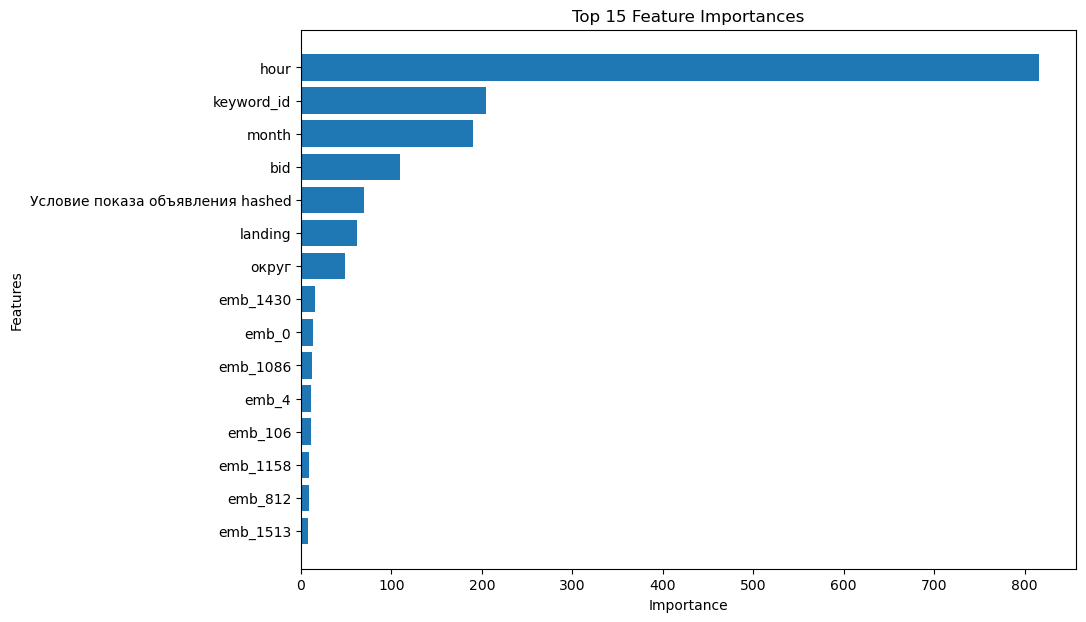

In [54]:
feature_importances = lgb_classifier.feature_importances_
feature_names = X_train.columns

sorted_idx = np.argsort(feature_importances)[-15:]

plt.figure(figsize=(10, 7))
plt.barh(feature_names[sorted_idx], feature_importances[sorted_idx])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 15 Feature Importances')
plt.show()